<b>Scratch Pad</b>  
User interaction data (ie # of comments, per subreddit etc)  - Can be used as word move weight/count  
Architecture - WMD fed into net with features as top X closest users (ie user 1,8,56,123) which are ordered by their inherent embedding distances from a reference user (ie a default sub user), could also include furthest users, add NLP/content features for fine tuning suggestions from close users.  
Need to deal with aging problem of recommender systems  
Need to update network gefx file  
identify users very far from you to introduce outside perspectives  
Center of gravity of user comments over time of user account age  
comment -> subreddit sequenced RNN, predict next subreddit to comment in?  
Use subbeddit tags and related subreddits for network connections in embedding network  
things learned - reading code from python packages  
temporal EDA (distribution of post month/year)  
Chrome extension to show visualization of selected users network compared to yours



In [1]:
import json
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ggplot import *
import networkx as nx
from networkx.readwrite import json_graph
from operator import itemgetter
from collections import Counter
from bs4 import BeautifulSoup
from pyemd import emd
import random
from sklearn.metrics import euclidean_distances
import tensorflow as tf
from tflearn.data_utils import to_categorical, pad_sequences
import tflearn
import SubRecommender
from sklearn.preprocessing import normalize
%matplotlib inline

<h1>Introduction</h1>
In this notebook, we explore a dataset compiled using Reddit's PRAW API in collecting historical user subbreddit comments. The goal of this analysis is to inform the development of a Recurrent Nueral Network model that can be used as a recommender system in recommending users new subreddits based on their historical subreddit commenting patterns.  

<h2>Dataset</h2>

The dataset was compiled using a python scrapper developed using Reddit's PRAW API. The raw data is a list of 3-tuples of [username,subreddit,utc timestamp]. Each row represents a single comments made by the user.

In [2]:
with open('data/train_reddit_data.json','r') as data_file:    
    reddit_data = json.load(data_file)

In [3]:
df = pd.DataFrame(reddit_data,columns=['user','subreddit','utc_stamp'])
df['utc_stamp'] = pd.to_datetime(df['utc_stamp'],unit='s')
df.head()

,user,subreddit,utc_stamp
0,kabanossi,photoshopbattles,2016-12-26 10:24:59
1,kabanossi,GetMotivated,2016-12-26 10:23:14
2,kabanossi,vmware,2016-12-26 10:21:16
3,kabanossi,carporn,2016-12-26 10:20:18
4,kabanossi,DIY,2016-12-26 10:17:59


In [4]:
print("Unique Users = " + str(len(df.groupby('user')['user'].nunique())))
print("Unique Subreddits = " + str(len(df.groupby('subreddit')['subreddit'].nunique())))
print("Total User Comments = " + str(df.shape[0]))

Unique Users = 22711
Unique Subreddits = 35030
Total User Comments = 14062334


<h2>Subreddit Data</h2>

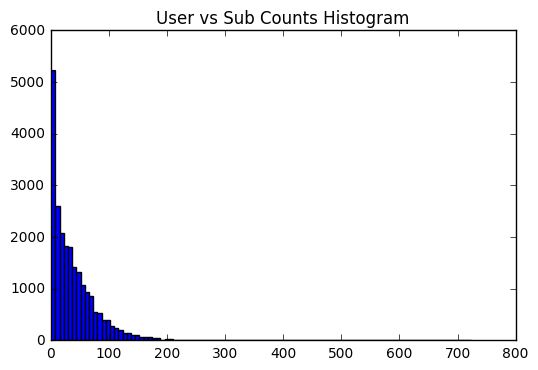

In [5]:
user_subs = df.groupby(['user'])['subreddit'].nunique()
plt.hist(user_subs.values, bins=100)
plt.title("User vs Sub Counts Histogram")
plt.show()

In [6]:
sub_users = df.groupby(['subreddit'])['user'].nunique()
data_tuple = pd.DataFrame([(sub,count) for sub,count in sub_users.items()],columns=["sub","user_count"])
sorted_df = data_tuple.sort_values(by='user_count',ascending=False)
sorted_df.head(50)

,sub,user_count
1404,AskReddit,14551
29618,pics,10325
24465,funny,10100
33332,todayilearned,9453
34709,worldnews,8640
34129,videos,8561
24609,gaming,8552
28551,news,7890
24791,gifs,7823
28183,movies,7068


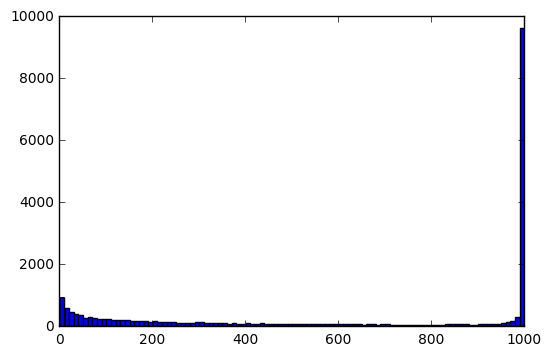

In [7]:
user_summary = df.groupby(by=['user'])['user']
plt.hist(user_summary.value_counts(), bins=100)
plt.show()

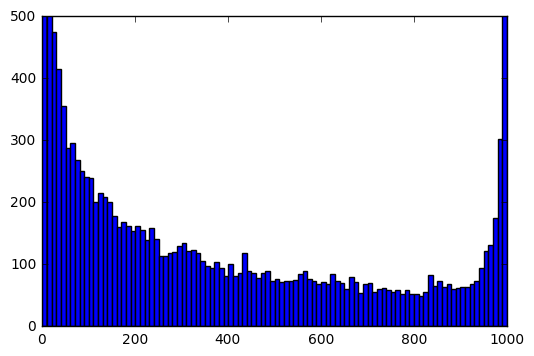

In [8]:
plt.hist(user_summary.value_counts(), bins=100)
axes = plt.gca()
axes.set_ylim([0,500])
plt.show()

In [9]:
users_vs_subs = []
current_user = reddit_data[0][0]
subs = []
interaction_count = 0
sub_discovery_time = []
usr_sub_discovery_time = [0]
user_subs_list = []
for i,comment in enumerate(reddit_data):
    if comment[0] != current_user:
        user_subs_list = [comment[1]]
        sub_discovery_time.append(usr_sub_discovery_time)
        usr_sub_discovery_time = []
        interaction_count = 0
        users_vs_subs.append(len(subs))
    elif comment[1] not in user_subs_list:
        usr_sub_discovery_time.append(interaction_count)
        interaction_count = 0
        user_subs_list.append(comment[1])
    if comment[1] not in subs:
        subs.append(comment[1])
    current_user = comment[0]
    if comment[1] != reddit_data[i-1][1]:
        interaction_count = interaction_count + 1

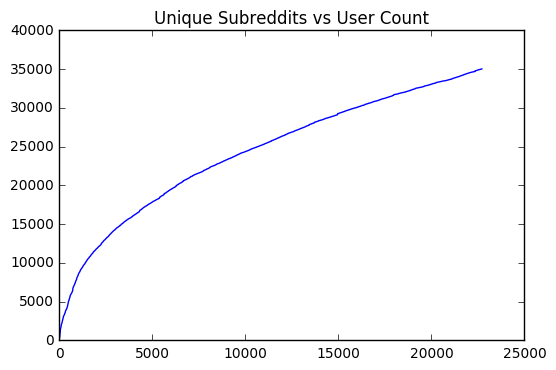

In [10]:
indexes = np.arange(len(users_vs_subs))
plt.plot(indexes,users_vs_subs)
plt.title("Unique Subreddits vs User Count")
plt.show()

<h1>Model Architecture</h1>

The hypothesis of the recommender model is that, given an ordered sequence of user subreddit interactions, patterns will emerge that favour the discovery of paticular new subreddits given that historical user interaction sequence. The intuition is, that as users interact with the Reddit ecosystem, they discover new subreddits of interest, but these new discoveries are influenced by the communities they have previously been interacting with. We can then train a model to recognize these emergent subreddit discoveries based on users historical subreddit discovery patterns. When the model is presented with a new sequence of user interaction, it "remembers" other users that historically had similiar interaction habits and recommend their subreddits that the current user has yet to discover.  

To build the training dataset, the subreddit interaction sequence for each user can be ordered and then split into chunks representing different periods of Reddit interaction and discovery. From each chunk, we can randomly remove a single subreddit from the interaction as the "discovered" subreddit and use it as our training label for the interaction sequences. This formulation brings with it a hyperparameter that will require tuning, namely the sequence size of each chunk of user interaction periods. There are also a couple design decisions needed that will create inherent assumptions in the model. This includes whether the labelled "discovered" subreddit should be randomly chosen from each interaction sequence, or should there be a more structured selection (ie. The latest subreddit to be interacted with in the sequence.) Also, should the sequences encode ever single comment interaction or only a subset, such as when the user switches between subreddits, as it may be possible to develop long sequences of the same subreddit repeatedly as the user engages in a conversation thread in a single subreddit over a short period. These design decisions will greatly influence the efficacy of the final model, and require exploration.

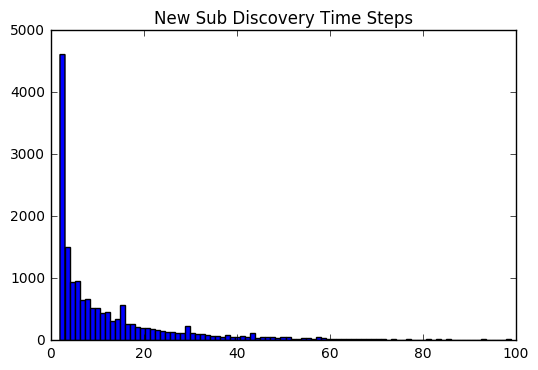

In [11]:
disc_times = [usr_dts[-1] for usr_dts in sub_discovery_time if usr_dts and usr_dts[-1] > 1 and  usr_dts[-1] <100]
plt.hist(disc_times , bins=90)
plt.title("New Sub Discovery Time Steps")
plt.show()

In [12]:
np.percentile(disc_times,95)

53.0

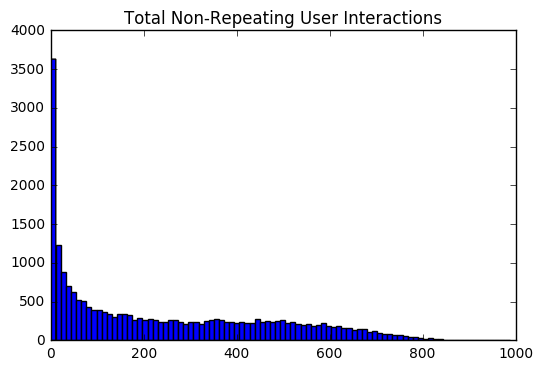

In [13]:
non_rep_interaction = [sum(usr_dts) for usr_dts in sub_discovery_time]
plt.hist(non_rep_interaction , bins=90)
plt.title("Total Non-Repeating User Interactions")
plt.show()

In [14]:
np.mean(non_rep_interaction)

244.85992954645531

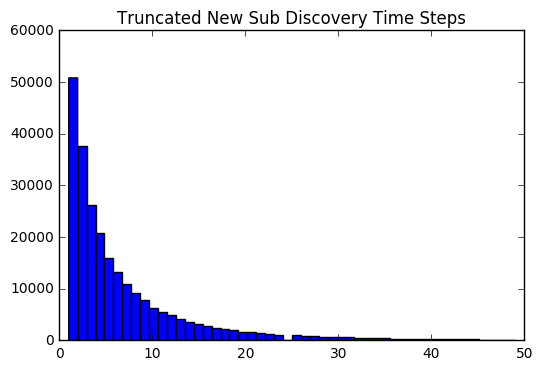

In [15]:
flt_disc_times = [dt for usr_dts in sub_discovery_time for dt in usr_dts[50:] if dt < 50]
plt.hist(flt_disc_times , bins=50)
plt.title("Truncated New Sub Discovery Time Steps")
plt.show()

In [16]:
np.mean(flt_disc_times)

6.7527359379867544

<h3>Network Embedding</h3>

In [17]:
soup = BeautifulSoup(open("data/embedding_network.html"),"html.parser")

In [18]:
graph_cords = {}
nodes = soup.findAll('node')
max_d =0

for nd in nodes:
    crds = nd.find('viz:position')
    if float(crds['x']) > max_d:
        max_d = float(crds['x'])
    if float(crds['y']) > max_d:
        max_d = float(crds['y'])

for nd in nodes:
    crds = nd.find('viz:position')
    graph_cords[nd['label']] = [float(crds['x'])/max_d,float(crds['y'])/max_d]

with open('data/embeddings.json','w') as data_file:    
    json.dump(graph_cords,data_file)

In [19]:
graph_cords['AdultToons']

[-0.4427980530112666, 0.012933187529738299]

<h3>Model Testing</h3>

In [2]:
import SubRecommender
import json
from collections import Counter
tst = SubRecommender.SubRecommender('data/train_reddit_data.json',
                                    sequence_chunk_size=15,min_seq_length=7,batch_size=256,min_count_thresh=100)
train_df = tst.load_train_df(load_file="data/training_sequences/13968_15_7_sequence_data.json")
tst.train(num_epochs=25,npartitions=12)

Training Step: 20175  | total loss: 6.53455
| Adam | epoch: 025 | loss: 6.53455 - acc: 0.0314 | val_loss: 7.67477 - val_acc: 0.0145 -- iter: 206432/206432
Training Step: 20175  | total loss: 6.53455
| Adam | epoch: 025 | loss: 6.53455 - acc: 0.0314 | val_loss: 7.67477 - val_acc: 0.0145 -- iter: 206432/206432
--


In [12]:
label_counter = Counter(tst.training_labels)
label_counter.most_common(1)

[(4, 1053)]

In [13]:
len(label_counter.keys())

5159

<h3>Baseline KNN Model</h3>

In [ ]:
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from scipy.sparse import csr_matrix


train,test = tst.split_train_test(train_df,0.8)
X_train = np.array(train['sub_seqs'])
y_train = np.array(train['sub_label']).astype(np.uint16)
X_test = np.array(test['sub_seqs'])
y_test =np.array(test['sub_label']).astype(np.uint16)

enc = OneHotEncoder(n_values=tst.vocab_size)
neigh = KNeighborsClassifier(n_neighbors=1,verbose=True)

X_train = pad_sequences(X_train, maxlen=tst.sequence_chunk_size, value=0.,padding='post')
X_test = pad_sequences(X_test, maxlen=tst.sequence_chunk_size, value=0.,padding='post')

enc.fit(X_train)

X_train = csr_matrix(enc.transform(X_train).toarray())
X_test = csr_matrix(enc.transform(X_test).toarray())

clf = neigh.fit(X_train, y_train,n_jobs=6)

accuracy_score(clf.predict(X_test),y_test)

In [4]:
def recommendation_accuracy(user_data,model,clf,enc=None):
    accuracies = []
    for usr,user_subs in user_data.items():
        user_seqs = tst.build_training_sequences(user_subs)
        training_sequences = [data[0] for data in user_seqs]
        training_labels = [data[1] for data in user_seqs]
        X_test = pad_sequences(training_sequences, maxlen=tst.sequence_chunk_size, value=0.,padding='post')
        if training_sequences:
            if model == 'knn':
                X_test = csr_matrix(enc.transform(X_test).toarray())
                recs = set(clf.predict(X_test))
            elif model == 'rnn':
                sub_probs = clf.predict(X_test)
                recs = set([probs.index(max(probs)) for probs in sub_probs])
            elif model == 'most_common':
                recs = [clf]
            accuracy = sum([1 if rec in training_labels else 0 for rec in recs])/len(recs)
            accuracies.append(accuracy)        
    return np.mean(accuracies)

In [5]:
with open('data/test_user_comment_sequence_cache.json','r') as data_file:    
    user_seqs = json.load(data_file)

In [6]:
recommendation_accuracy(user_seqs,'rnn',tst.model)

0.17678381685555289

In [7]:
recommendation_accuracy(user_seqs,'most_common',4)

0.025000000000000001

<h3>Word Movers Distance</h3>

In [ ]:
def pairwise_emd(user_A,user_B,graph_cords):
    set_subs = [sub for sub in set(list(user_A.keys())+list(user_A.keys())) if sub in graph_cords.keys()]
    sub_cords = np.array([graph_cords[sub] for sub in set_subs]) 
    A_interacts = np.array([user_A[sub] if sub in list(user_A.keys()) else 0 for sub in set_subs])
    B_interacts = np.array([user_B[sub] if sub in list(user_B.keys()) else 0 for sub in set_subs])
    euc_dists = euclidean_distances(sub_cords,sub_cords)
    emd_dist = emd(A_interacts.astype(np.double), B_interacts.astype(np.double), euc_dists.astype(np.double))
    return emd_dist

In [ ]:
pairwise_emd(grouped['subreddit']['count']['-DEAD-'].sort_values(ascending=False),
             grouped['subreddit']['count']['-Doomcrow-'].sort_values(ascending=False),graph_cords)